# `pyGIMLi(emg3d)` - Inversion

**Using `pyGIMLi` as an inversion framework for `emg3d` computations.**

=> Create an environment using the provided `environment.yml`: `mamba env create`.

**Current Limitations**
- Only isotropic models supported

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm

import emg3d

# Requires currently branch inversion:
# pip install git+https://github.com/emsig/emg3d@inversion
from emg3d.inversion.pygimli import Inversion

## Load survey (incl. data), initial model, and create a Simulation

In [2]:
inp_data = emg3d.load('pginv-7x7.h5')        # Finer model (but still coarse)

inp_survey = inp_data['survey']
inp_model = inp_data['model']
inp_grid = inp_model.grid
inp_model

Data loaded from «/home/dtr/Codes/dev-pygimli-emg3d/pginv-7x7.h5»
[emg3d v1.8.1 (format 1.0) on 2024-01-22T19:05:14.069718].


Model: resistivity; isotropic; 142 x 62 x 24 (211,296)

In [3]:
# The model is resistivity. Change it to conductivity
# TODO: make this internally happen, so that pyGIMLi
# always gets a conductivity model!
con_model = emg3d.Model(inp_grid, 1/inp_model.property_x, mapping='Conductivity')
con_model

Model: conductivity; isotropic; 142 x 62 x 24 (211,296)

In [4]:
# For dev-purposes, we only select one source
# [for dev-purposes it is also a very simple model]
inp_survey = inp_survey.select(sources=['TxED-1', 'TxED-7'], frequencies='f-1')
#inp_survey = inp_survey.select(sources=['TxED-1', 'TxED-7'], frequencies=['f-1', 'f-5'])
#inp_survey = inp_survey.select(frequencies='f-1')
#inp_survey = inp_survey.select(sources=['TxED-1', 'TxED-3', 'TxED-5', 'TxED-7'], frequencies=['f-1', 'f-3', 'f-5'])
inp_survey

:: Survey ::

<xarray.Dataset>
Dimensions:   (src: 2, rec: 57, freq: 1)
Coordinates:
  * src       (src) <U6 'TxED-1' 'TxED-7'
  * rec       (rec) <U7 'RxEP-01' 'RxEP-02' 'RxEP-03' ... 'RxEP-56' 'RxEP-57'
  * freq      (freq) <U3 'f-1'
Data variables:
    observed  (src, rec, freq) complex128 (5.609229984187803e-08-2.5645703392...
Attributes:
    noise_floor:     1e-15
    relative_error:  0.03

## Create a Starting Model

In [5]:
hx = np.ones(58)*250.0
hy = np.ones(26)*250.0
hz = np.ones(15)*250.0
grid = emg3d.TensorMesh([hx, hy, hz], [-7250, -3250, -3500])

model = emg3d.Model(grid, 1.0, mapping='Conductivity')
model.property_x[:, :, -1:] = 3.33

# QC
grid

TensorMesh: 22,620 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     58     -7,250.00      7,250.00    250.00    250.00    1.00
   y     26     -3,250.00      3,250.00    250.00    250.00    1.00
   z     15     -3,500.00        250.00    250.00    250.00    1.00

## Create a Simulation

In [6]:
# Create an emg3d Simulation instance
sim = emg3d.simulations.Simulation(
    survey=inp_survey,
    model=model,
    gridding='both', #'same',  # I would like to make that more flexible in the future
    gridding_opts={'vector': 'xyz'},
    max_workers=15,    # Adjust as needed
    receiver_interpolation='linear',  # Currently necessary for the gradient
    #solver_opts={'plain': True, 'maxit': 1},  # Just for dev-purpose
    ### Tolerance: different ones for forward and adjoints
    solver_opts={'tol': 1e-3},                # Just for dev-purpose
    tqdm_opts=False,  # Switch off verbose progress bars
    #verb=3,
)
sim

:: Simulation ::

- Survey: 2 sources; 57 receivers; 1 frequencies
- Model: conductivity; isotropic; 58 x 26 x 15 (22,620)
- Gridding: Frequency- and source-dependent grids; 80 x 40 x 32 (102,400)

## Instantiate and run inversion

In [7]:
INV = Inversion(fop=sim, verbose=True, debug=True)
INV.inv.setCGLSTolerance(10)  # is _absolute_, not _relative_
INV.inv.setMaxCGLSIter(30)
#INV.dataTrans = pg.trans.TransSymLog(sim.survey.noise_floor)

# , zWeight=0.2
# , correlationLengths=[1000, 1000, 300])

INV.setRegularization(0, limits=(0.001, 2), startModel=1)
INV.setRegularization(1, limits=(3.32, 3.34), startModel=3.33) # , single=True)
# 0 only damping (minimum length; only useful with good starting model and isReference=True in INV)
# 1 1st deriv - smoothing
# 2 2nd deriv
# 10, 20 - mixed form


# außerdem kann man der Inversion inv.setPostStep(fct) und inv.setPreStep(fct) mitgeben,
# die als def fct(iter, inv): die Iterationszahl und die Inversionsinstanz bekommt,
# damit kann man machen was man will 

In [8]:
%%time
errmodel = INV.run(
    maxIter=1, # just to test
    lam=1,  # btw 1-100
    #verbose=True,
    #startModel=...,
    #isReference=True,
)

24/01/24 - 00:19:28 - pyGIMLi - INFO - Created startmodel from region infos: 22620 [1.0,...,3.33]
24/01/24 - 00:19:28 - pyGIMLi - INFO - Starting inversion.


min/max(dweight) = 1410.76/3.32016e+13
fop: <emg3d.inversion.pygimli.Kernel object at 0x7fdf672897b0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x7fdf673ff450>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x7fdf673ff530>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x7fdf673ff5a0>
min/max (data): -2.8e-08/5.9e-08
min/max (error): 3%/1.0e+10%
min/max (start model): 1/3.33
--------------------------------------------------------------------------------
use model trans from RegionManager
min/max(dweight) = 1410.76/3.32016e+13
Building constraints matrix
inv.iter 0 ... chi² =  314.41
--------------------------------------------------------------------------------
inv.iter 1 ... constraint matrix of size(nBounds x nModel) 63584 x 22620
calculating jacobian matrix (forced=1)...... 1.0549e-05 s
C size: 22620 x 63584
min data = -2.76523e-08 max data = 5.89076e-08 (200)
min error = 0.0300031 max error = 1e+08 (200)
min response = -3.02298e-08 max r

## Plots

In [9]:
# Add inversion result to data;
# I should wrap these few lines into a function, as they are used above as well
idata = np.ones(sim.survey.shape, dtype=sim.data.observed.dtype)*np.nan
x = np.asarray(INV.response)
idata[sim.survey.isfinite] = x[:x.size//2] + 1j*x[x.size//2:]
sim.survey.data['inv'] = sim.survey.data.observed.copy(data=idata)

# Compute the 2-layer model as comparison
sim.clean('computed')
sim.model = model
sim.compute()  # <- puts it into 'synthetic'

In [10]:
# Store final model as model to be saved with the simulation
sim.model = emg3d.Model(grid, np.array(INV.model), mapping='Conductivity')
sim.to_file('Simulation-7x7-Test.h5')

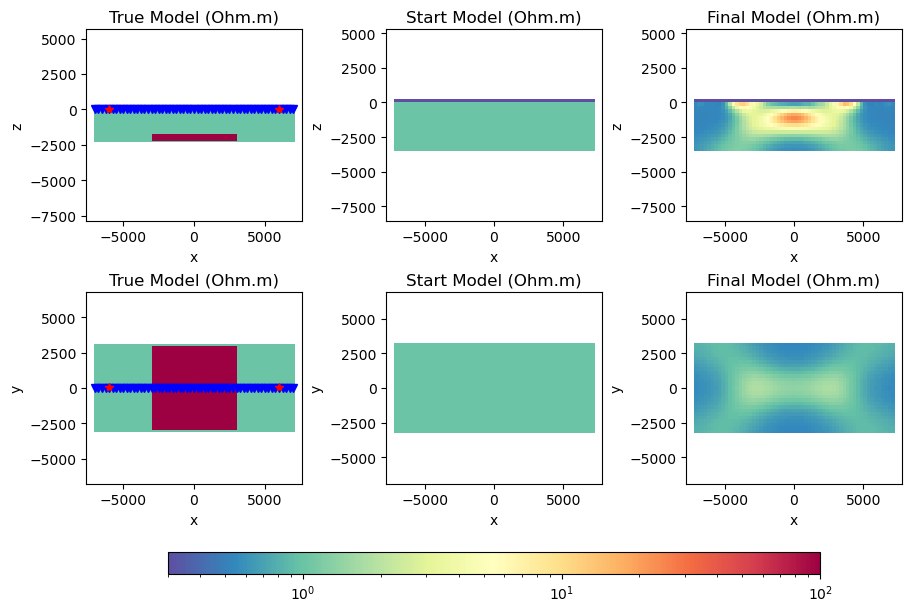

In [11]:
popts1 = {'cmap':'Spectral_r','norm':LogNorm(vmin=0.3, vmax=100)}
popts2 = {'edgecolors': 'grey', 'linewidth': 0.5, 'cmap':'Spectral_r','norm':LogNorm(vmin=0.3, vmax=100)}
opts = {'v_type': 'CC', 'normal': 'Y'}

rec_coords = sim.survey.receiver_coordinates()
src_coords = sim.survey.source_coordinates()

fig, axs = plt.subplots(2, 3, figsize=(9, 6), constrained_layout=True)#, sharex=True, sharey='col')
(ax1, ax2, ax3), (ax4, ax5, ax6) = axs

# True model
out1, = inp_grid.plot_slice(inp_data['true_model'].property_x.ravel('F'), ax=ax1, pcolor_opts=popts1, **opts)
ax1.set_title(f"True Model (Ohm.m)")
ax1.plot(rec_coords[0], rec_coords[1], 'bv')
ax1.plot(src_coords[0], src_coords[1], 'r*')

# Start model
out2, = model.grid.plot_slice(1/model.property_x.ravel('F'), ax=ax2, pcolor_opts=popts1, **opts)
ax2.set_title(f"Start Model (Ohm.m)")

# Final inversion model
out3, = model.grid.plot_slice(1/sim.model.property_x.ravel('F'), ax=ax3, pcolor_opts=popts1, **opts)
ax3.set_title(f"Final Model (Ohm.m)")

opts['normal'] = 'Z'
opts['ind'] = 4

# True model
out4, = inp_grid.plot_slice(inp_data['true_model'].property_x.ravel('F'), ax=ax4, pcolor_opts=popts1, **opts)
ax4.set_title(f"True Model (Ohm.m)")
ax4.plot(rec_coords[0], rec_coords[2], 'bv')
ax4.plot(src_coords[0], src_coords[2], 'r*')

# Start model
out5, = model.grid.plot_slice(1/model.property_x.ravel('F'), ax=ax5, pcolor_opts=popts1, **opts)
ax5.set_title(f"Start Model (Ohm.m)")

# Final inversion model
out6, = model.grid.plot_slice(1/sim.model.property_x.ravel('F'), ax=ax6, pcolor_opts=popts1, **opts)
ax6.set_title(f"Final Model (Ohm.m)")

for ax in axs.ravel():
    ax.axis('equal')

plt.colorbar(out1, ax=axs, orientation='horizontal', fraction=.1, shrink=.8, aspect=30)
plt.savefig('ModelFit-7x7-Test.png', dpi=300)

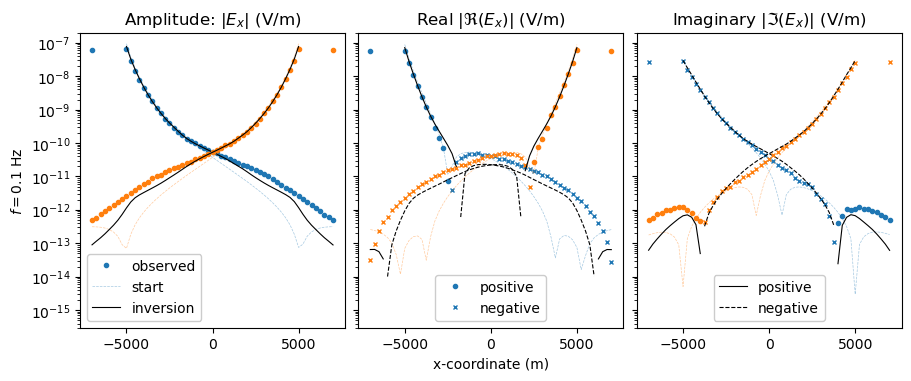

In [12]:
def pos(data):
    """Return positive data; set negative data to NaN."""
    return np.array([x if x > 0 else np.nan for x in data])


def neg(data):
    """Return -negative data; set positive data to NaN."""
    return np.array([-x if x < 0 else np.nan for x in data])

height = sim.survey.shape[2]*1.7+2
fig, axs = plt.subplots(sim.survey.shape[2], 3, figsize=(9, height), constrained_layout=True, sharex=True, sharey=True)
axs = np.atleast_2d(axs)  # So it works if only 1 freq

# Data
obs = sim.data.observed
syn = sim.data.inv
syn.data[~np.isfinite(obs.data)] = np.nan+1j*np.nan
two = sim.data.synthetic
two.data[~np.isfinite(obs.data)] = np.nan+1j*np.nan

rec_coords = sim.survey.receiver_coordinates()

for ii, freq in enumerate(sim.survey.frequencies.keys()):
    for i, src in enumerate(sim.survey.sources.keys()):
        #if i in [1, 3, 5]:
        #    continue
        
        # Observed data
        axs[ii, 0].plot(rec_coords[0], abs(obs.loc[src, :, freq].data), f"C{i}.",
                        label='observed' if i == 0 else '')
        axs[ii, 1].plot(rec_coords[0], pos(obs.loc[src, :, freq].data.real), f"C{i}.",
                        label='positive' if i == 0 else '')
        axs[ii, 1].plot(rec_coords[0], neg(obs.loc[src, :, freq].data.real), f"C{i}x", ms=3,
                        label='negative' if i == 0 else '')
        axs[ii, 2].plot(rec_coords[0], pos(obs.loc[src, :, freq].data.imag), f"C{i}.")
        axs[ii, 2].plot(rec_coords[0], neg(obs.loc[src, :, freq].data.imag), f"C{i}x", ms=3)
        
        # Start model
        axs[ii, 0].plot(rec_coords[0], abs(two.loc[src, :, freq].data), f"C{i}--", alpha=.4, lw=0.5,
                        label='start' if i == 0 else '')
        axs[ii, 1].plot(rec_coords[0], abs(two.loc[src, :, freq].data.real), f"C{i}--", alpha=.4, lw=0.5)
        axs[ii, 2].plot(rec_coords[0], abs(two.loc[src, :, freq].data.imag), f"C{i}--", alpha=.4, lw=0.5)
        
        # Inverted data
        axs[ii, 0].plot(rec_coords[0], abs(syn.loc[src, :, freq].data), f"k-", lw=0.8,
                        label='inversion' if i == 0 else '')
        axs[ii, 1].plot(rec_coords[0], pos(syn.loc[src, :, freq].data.real), f"k-", lw=0.8)
        axs[ii, 1].plot(rec_coords[0], neg(syn.loc[src, :, freq].data.real), f"k--", lw=0.8)
        axs[ii, 2].plot(rec_coords[0], pos(syn.loc[src, :, freq].data.imag), f"k-", lw=0.8,
                        label='positive' if i == 0 else '')
        axs[ii, 2].plot(rec_coords[0], neg(syn.loc[src, :, freq].data.imag), f"k--", lw=0.8,
                        label='negative' if i == 0 else '')
        

    axs[ii, 0].set_ylabel(f'$f={sim.survey.frequencies[freq]}$ Hz')     

        
axs[0, 0].set_yscale('log')
axs[0, 0].set_ylim([3e-16, 2e-7])

axs[0, 0].set_title('Amplitude: $|E_x|$ (V/m)')
axs[0, 1].set_title('Real $|\Re(E_x)|$ (V/m)')
axs[0, 2].set_title('Imaginary $|\Im(E_x)|$ (V/m)')

axs[0, 0].legend(framealpha=1)
axs[0, 1].legend(framealpha=1)
axs[0, 2].legend(framealpha=1)

axs[-1, 1].set_xlabel('x-coordinate (m)')
plt.savefig('ResponseFit-7x7-Test.png', dpi=300)
plt.show()

In [13]:
emg3d.Report()

--------------------------------------------------------------------------------
  Date: Wed Jan 24 00:21:46 2024 CET

                OS : Linux
            CPU(s) : 16
           Machine : x86_64
      Architecture : 64bit
               RAM : 31.0 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.10.13 | packaged by conda-forge | (main, Oct 26 2023, 18:07:37)
  [GCC 12.3.0]

             numpy : 1.24.4
             scipy : 1.12.0
             numba : 0.58.1
             emg3d : 1.8.3.dev2+g4da60c5
           empymod : 2.2.2
            xarray : 2024.1.0
        discretize : 0.10.0
              h5py : 3.9.0
        matplotlib : 3.8.2
              tqdm : 4.66.1
           IPython : 8.20.0
           pygimli : 1.4.6
            pgcore : 1.4.0
--------------------------------------------------------------------------------